# Forest Cover
## Data Description

In [830]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas.api.types import CategoricalDtype
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, skew, kurtosis
from statsmodels.graphics.mosaicplot import mosaic

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 120)
sns.set_theme()

# load dataset
forest_cover = pd.read_csv("forest_cover.csv")

### Data shape

In [831]:
forest_cover.shape

(30860, 56)

### Data Type

In [832]:
data_type = pd.DataFrame(forest_cover.dtypes, columns=["Data Type"])
data_type.index.name = "Attribute"
data_type.style.set_caption("Appendix 1. Data Types of Forest Cover Attributes")

,Data Type
Attribute,
Unnamed: 0,int64
Elevation,float64
Aspect,float64
Slope,float64
Horizontal_Distance_To_Hydrology,float64
Vertical_Distance_To_Hydrology,float64
Horizontal_Distance_To_Roadways,float64
Hillshade_9am,float64
Hillshade_Noon,float64


### Overall Missingness

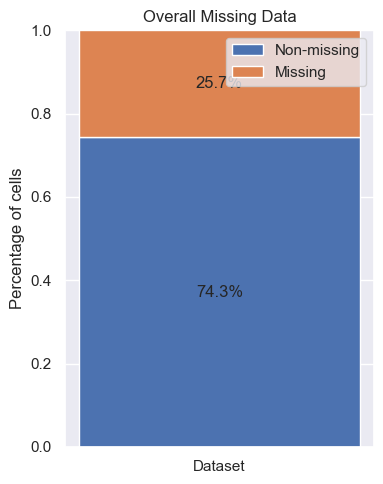

In [833]:
total_cells = forest_cover.shape[0] * forest_cover.shape[1]
total_missing = int(forest_cover.isna().sum().sum())
p_missing = total_missing / total_cells
p_non_missing = 1 - p_missing

fig, ax = plt.subplots(figsize=(4, 5))
ax.bar(["Dataset"], [p_non_missing], label="Non-missing")
ax.bar(["Dataset"], [p_missing], bottom=[p_non_missing], label="Missing")
ax.set_ylim(0, 1)
ax.set_ylabel("Percentage of cells")
ax.set_title("Overall Missing Data")
ax.legend(loc="upper right")

ax.text(0, p_non_missing/2, f"{p_non_missing*100:.1f}%", ha="center", va="center")
ax.text(0, p_non_missing + p_missing/2, f"{p_missing*100:.1f}%", ha="center", va="center")
plt.tight_layout()
plt.show()

### Categorical vairbales

In [834]:
categorical_cols = forest_cover.select_dtypes(include=["object", "category"]).columns

cat_summary = pd.DataFrame({
    "Variable": categorical_cols,
    "Unique Categories": [forest_cover[col].unique().tolist() for col in categorical_cols],
    "No. of Categories": [forest_cover[col].nunique() for col in categorical_cols]
})

cat_summary.style.set_caption("Appendix 2. Summary of Categorical Variables")

,Variable,Unique Categories,No. of Categories
0,Forest_Cover,"['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Aspen', 'Douglas-fir', 'Krummholz', 'Cottonwood/Willow']",7


## Data Cleaning and Processing
### Removal of Irrelevant Columns 

In [835]:
# Load dataset 
forest_cover = pd.read_csv("forest_cover.csv", index_col=0)

### Data Type Standaridization

In [836]:
# standardise numeric dtype
numeric_vars = forest_cover.select_dtypes(include="number").columns.tolist()
forest_cover[numeric_vars] = forest_cover[numeric_vars].astype("float64")

### Duplication of Records

In [837]:
# remove duplicat rows
forest_cover = forest_cover.drop_duplicates()

### Consolidation of One-Hot Encoded Variables

In [838]:
# Define groups
soil_cols = [c for c in forest_cover.columns if c.startswith("Soil_Type")]
area_cols = ["Neota", "Rawah", "Comanche Peak", "Cache la Poudre"]

# Soil_Type: fill missing with 0, if sum of each row is 1 → "Known" else (0 or >1) → "Unknown"
tmp_soil = forest_cover[soil_cols].fillna(0)
soil_row_sums = tmp_soil.sum(axis=1)
forest_cover["Soil_Type"] = np.where(soil_row_sums == 1, "Known", "Unknown")
# Drop the original one-hot encoded soil columns
forest_cover = forest_cover.drop(columns=soil_cols)

# Wilderness_Area: fill missing with 0, if exactly one area is marked, use its name otherwise assign "Other"
tmp_area = forest_cover[area_cols].fillna(0)
area_row_sums = tmp_area.sum(axis=1)
area_labels = tmp_area.idxmax(axis=1)
forest_cover["Wilderness_Area"] = np.where(area_row_sums == 1, area_labels, "Other")
# Drop the original one-hot wilderness area columns
forest_cover = forest_cover.drop(columns=area_cols)
# Ensure the target variable is categorical for modeling
forest_cover["Forest_Cover"] = forest_cover["Forest_Cover"].astype("category")

### Detection and Treatment of Outliers
#### Invalid-Range Screening -> Set to NaN


In [839]:
valid_ranges = { 
    "Slope": (0, 90), 
    "Hillshade_9am": (0, 255), 
    "Hillshade_Noon": (0, 255), 
    "Hillshade_3pm": (0, 255), 
    "Aspect": (0, 360),
    "Elevation" : (0, None),
    "Horizontal_Distance_To_Roadways": (0, None),
    "Horizontal_Distance_To_Hydrology": (0, None),
    "Horizontal_Distance_To_Fire_Points": (0, None)} 

for col, (low, high) in valid_ranges.items():
    if low is not None:
        forest_cover.loc[forest_cover[col] < low, col] = np.nan
    if high is not None:
        forest_cover.loc[forest_cover[col] > high, col] = np.nan

#### Visual scan of Extremes

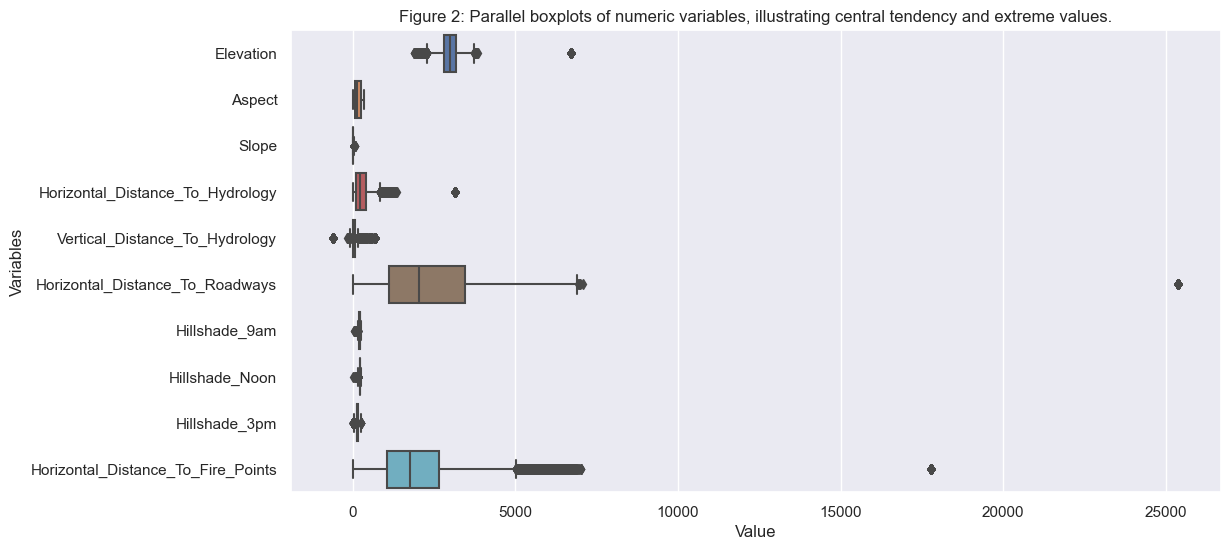

In [840]:
numeric_vars = forest_cover.select_dtypes(include="number").columns.tolist()
plt.figure(figsize=(12,6))
sns.boxplot(data=forest_cover[numeric_vars], orient="h")
plt.title("Figure 2: Parallel boxplots of numeric variables, illustrating central tendency and extreme values.")
plt.xlabel("Value")
plt.ylabel("Variables")
plt.show()

### Distribution of Categorial Variables


In [841]:
# plot proportions per catrgory
def plot_categorical_distribution(data, figurenumber: int = 1, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    categorical_vars = data.select_dtypes(include=["object", "category"]).columns
    categorical_vars = [col for col in categorical_vars if col not in exclude_cols]
    figure_counter = 1
    for var in categorical_vars:
        non_na_data = data[data[var].notna()]
        if non_na_data.empty:
            continue
        prop_counts = non_na_data[var].value_counts(normalize=True)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=prop_counts.index, y=prop_counts.values)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Figure {figurenumber}.{figure_counter}: Proportion of Categories in {var}")
        plt.xlabel("Category")
        plt.ylabel("Proportion")
        plt.tight_layout()
        plt.show() 
        figure_counter += 1

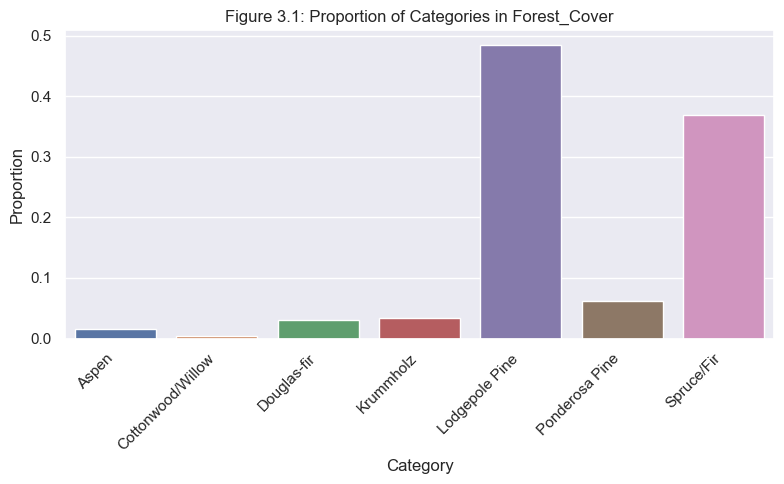

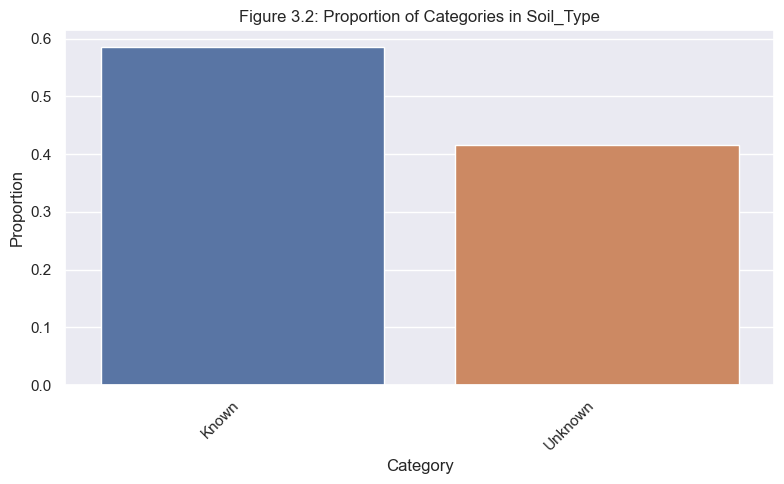

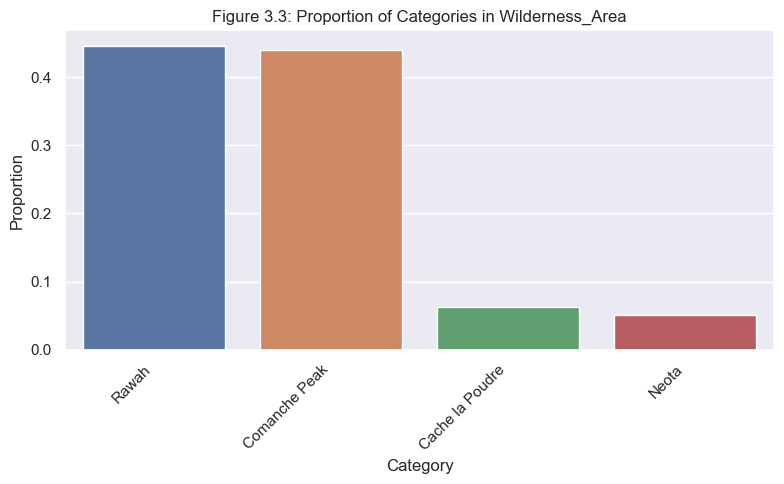

In [842]:
plot_categorical_distribution(forest_cover, 3)

In [843]:
# Forest_Cover: collapse rare → Other_Forest (only keep Lodgepole Pine, Spruce/Fir explicitly)
forest_cover["Forest_Cover"] = forest_cover["Forest_Cover"].cat.add_categories(["Other_Forest"])
forest_cover["Forest_Cover"] = forest_cover["Forest_Cover"].where(forest_cover["Forest_Cover"].isin(["Lodgepole Pine","Spruce/Fir"]),"Other_Forest")
forest_cover["Forest_Cover"] = forest_cover["Forest_Cover"].cat.remove_unused_categories()
# Wilderness_Area: combine smallest into "Other" if present
forest_cover["Wilderness_Area"] = forest_cover["Wilderness_Area"].replace({"Neota": "Other", "Cache la Poudre": "Other"}).astype("category")

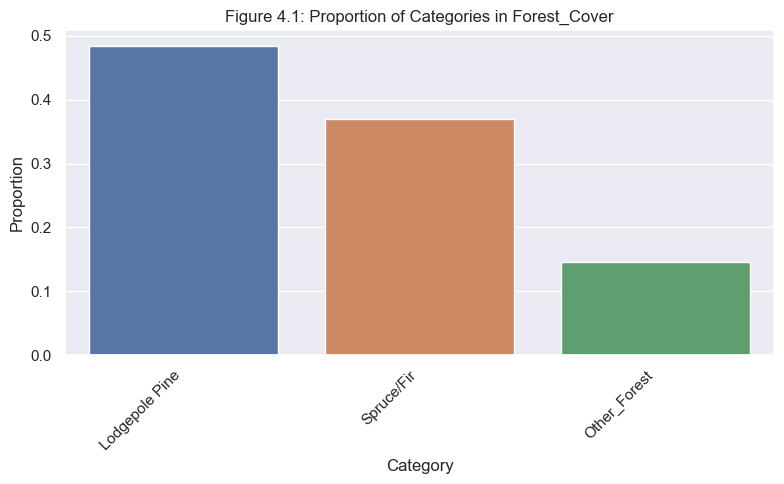

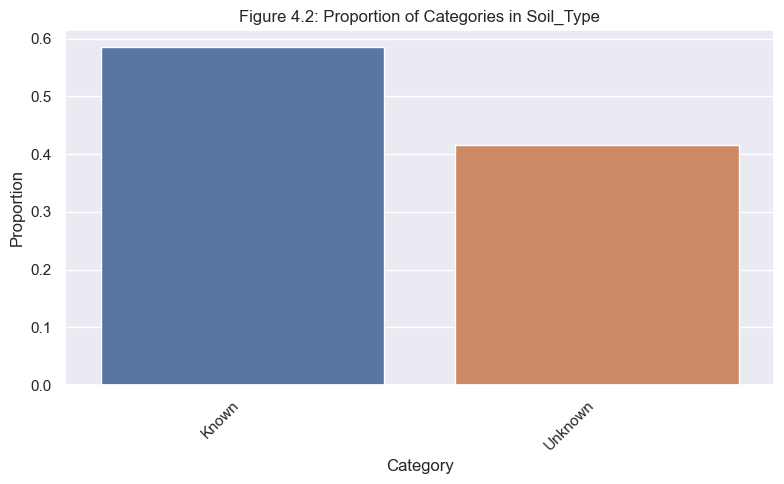

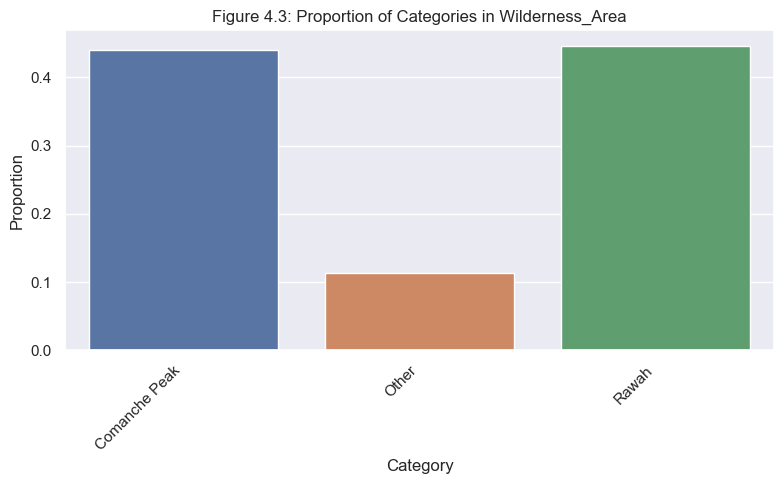

In [844]:
plot_categorical_distribution(forest_cover, 4)

### Handling of Missing Values


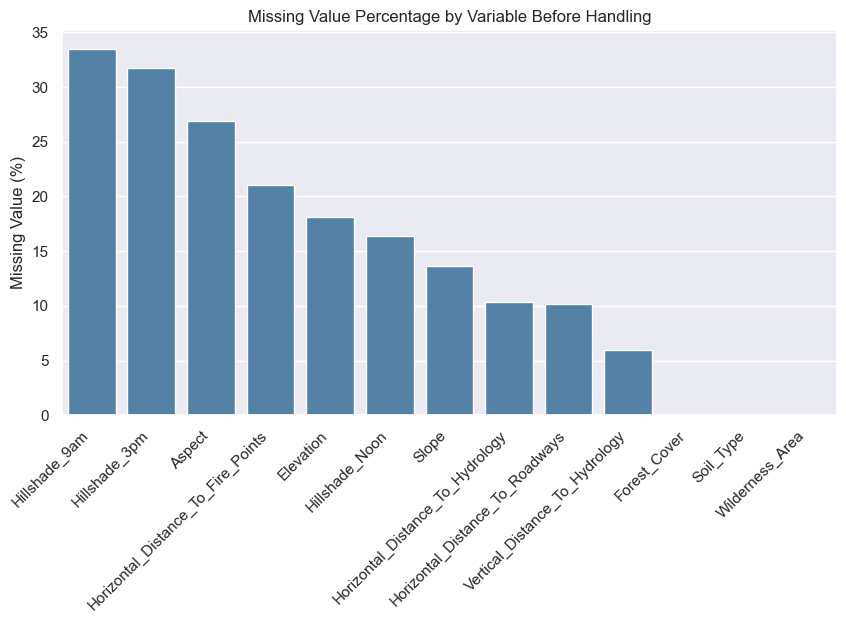

In [845]:
missing = forest_cover.isna().mean().sort_values(ascending=False) * 100
missing_table = pd.DataFrame({
    "Variable": missing.index,
    "Missing %": missing.values})
plt.figure(figsize=(10,5))
sns.barplot(x=missing.index, y=missing.values, color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing Value (%)")
plt.title("Missing Value Percentage by Variable Before Handling")
plt.show()

In [846]:
# Aspect → sin/cos; keep a missingness indicator; drop raw Aspect
forest_cover["Aspect_sin"] = np.sin(np.deg2rad(forest_cover["Aspect"]))
forest_cover["Aspect_cos"] = np.cos(np.deg2rad(forest_cover["Aspect"]))
forest_cover["Aspect_missing"] = forest_cover["Aspect"].isna().astype(float)
forest_cover = forest_cover.drop(columns=["Aspect"])
# Hillshade: combine 9am & 3pm (drop original and Noon to avoid collinearity later)
forest_cover["Hillshade_Mean_9_3"] = forest_cover[["Hillshade_9am", "Hillshade_3pm"]].mean(axis=1, skipna=True)
forest_cover = forest_cover.drop(columns=["Hillshade_9am", "Hillshade_3pm","Hillshade_Noon"])
# Fire points: missingness flag
forest_cover["FirePoint_Missing"] = forest_cover["Horizontal_Distance_To_Fire_Points"].isna().astype(float)
# Median Imputation for Numeric Predictors
numeric_vars = forest_cover.select_dtypes(include=["number"]).columns.tolist()
additional = {"Aspect_sin", "Aspect_cos"}
exclude = {"Horizontal_Distance_To_Fire_Points"}
impute_vars = [c for c in (numeric_vars + list(additional)) if c not in exclude]
for col in impute_vars:
    if forest_cover[col].isna().any():
        median_val = forest_cover[col].median()
        forest_cover[col] = forest_cover[col].fillna(median_val)

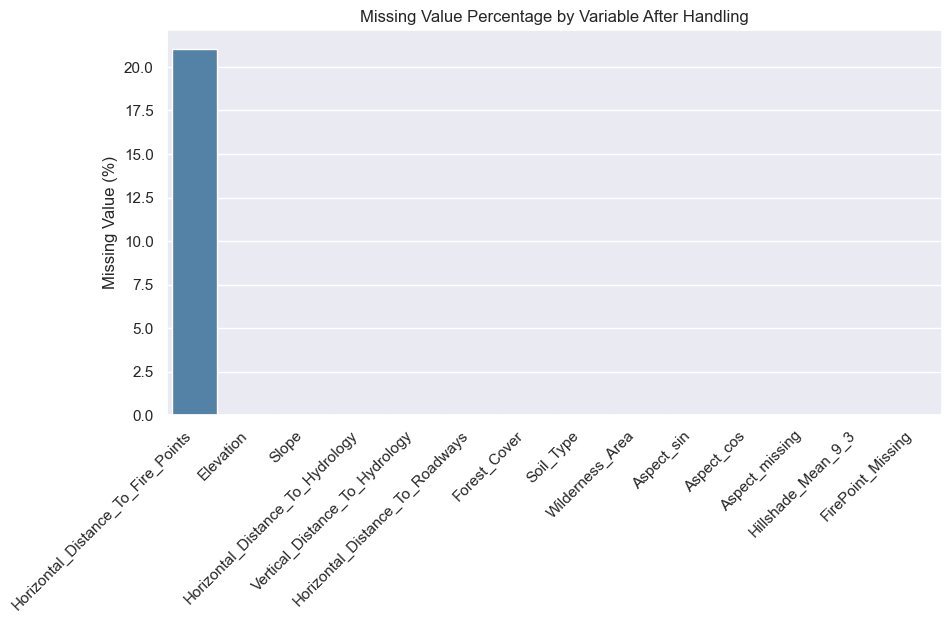

In [847]:
missing = forest_cover.isna().mean().sort_values(ascending=False) * 100
missing_table = pd.DataFrame({
    "Variable": missing.index,
    "Missing %": missing.values})
plt.figure(figsize=(10,5))
sns.barplot(x=missing.index, y=missing.values, color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing Value (%)")
plt.title("Missing Value Percentage by Variable After Handling")
plt.show()

### Independent and Dependent Variables

In [848]:
new_order = [
    "Elevation",
    "Slope",
    "Aspect_sin", "Aspect_cos", 
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Horizontal_Distance_To_Fire_Points",
    "Hillshade_Mean_9_3",
    "Soil_Type", "Wilderness_Area",
    "Forest_Cover",
    "Aspect_missing", "FirePoint_Missing"]

forest_cover = forest_cover[new_order]

for col in forest_cover.columns:
    if pd.api.types.is_integer_dtype(forest_cover[col]):
        if forest_cover[col].isna().any():
            forest_cover[col] = forest_cover[col].astype("float64")
        else:
            forest_cover[col] = forest_cover[col].astype("int64")

data_type = pd.DataFrame(forest_cover.dtypes, columns=["Data Type"])
data_type.index.name = "Attribute"
dependent = data_type.loc[["Forest_Cover"]]
dependent.style.set_caption("Table 2. Data Type for Dependent Variable")

,Data Type
Attribute,
Forest_Cover,category


In [849]:
# ensure type consistency
independent = data_type.drop("Forest_Cover")
independent.style.set_caption("Table 3. Data Types for Independent Variable")

,Data Type
Attribute,
Elevation,float64
Slope,float64
Aspect_sin,float64
Aspect_cos,float64
Horizontal_Distance_To_Hydrology,float64
Vertical_Distance_To_Hydrology,float64
Horizontal_Distance_To_Roadways,float64
Horizontal_Distance_To_Fire_Points,float64
Hillshade_Mean_9_3,float64


### Save Cleaned Dataset

In [850]:
forest_cover.to_csv("cleaned_forest_cover.csv", index = False)

## Exploratory Data Analysis

### Correlation Analysis of Numerical Predictors

In [851]:
num_cols = [
    "Elevation","Slope","Aspect_sin","Aspect_cos","Aspect_missing",
    "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points",
    "FirePoint_Missing","Hillshade_Noon","Hillshade_Mean_9_3"]
num_cols = [c for c in num_cols if c in forest_cover.columns]

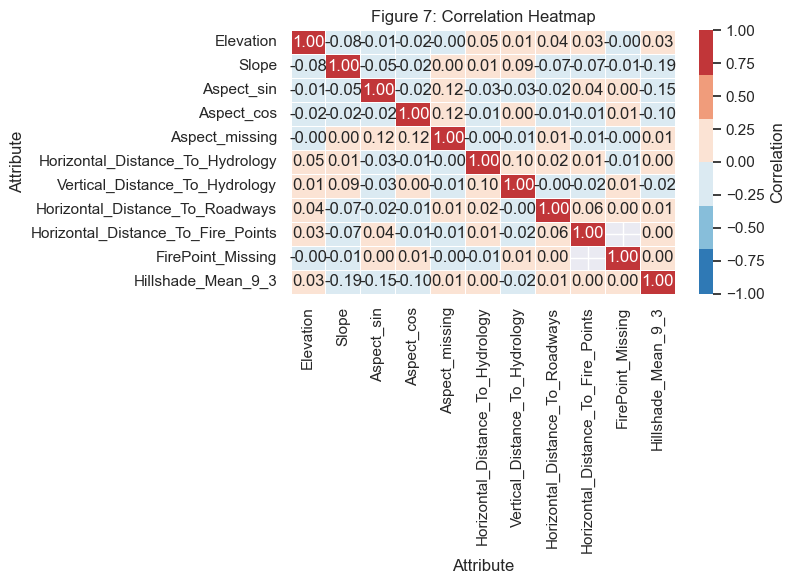

In [852]:
corr = forest_cover[num_cols].corr(method="pearson")
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap=sns.color_palette("RdBu_r"), center=0,
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"label": "Correlation"})
plt.title("Figure 7: Correlation Heatmap")
plt.tight_layout()
plt.show()

### Distributional Characteristics of Selected Numerical Variables

In [853]:
selected_vars = [
    "Elevation",
    "Slope",
    "Horizontal_Distance_To_Roadways",
    "Vertical_Distance_To_Hydrology"]

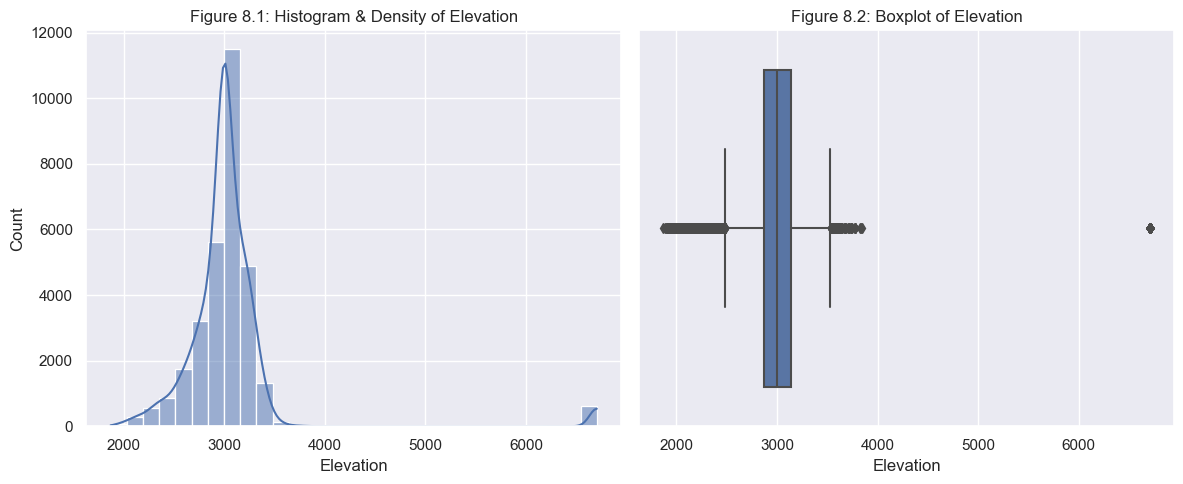

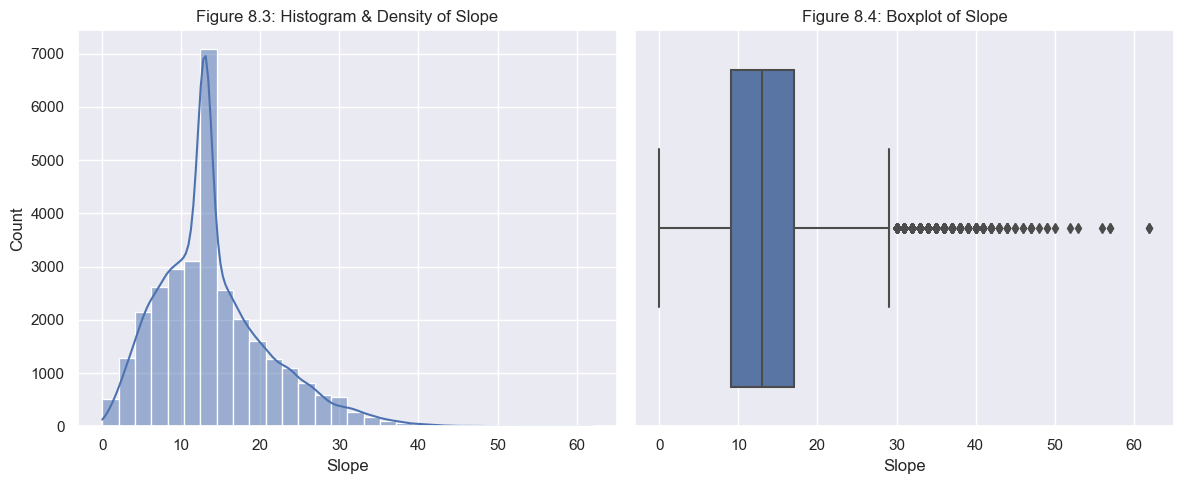

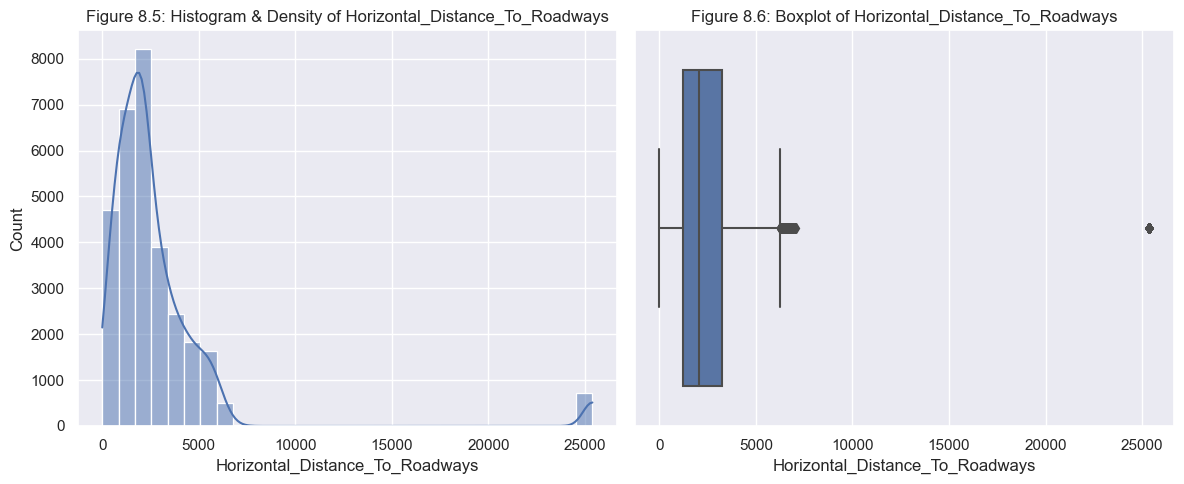

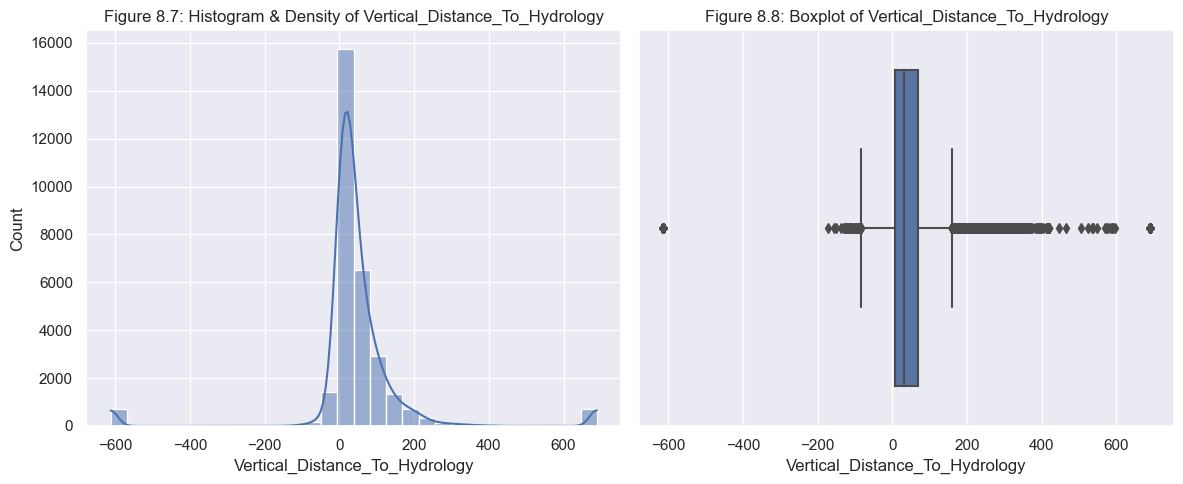

In [854]:
figure_counter = 1
for var in selected_vars:
    plt.figure(figsize=(12, 5))
    # Histogram + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(forest_cover[var], bins=30, kde=True)
    plt.title(f"Figure 8.{figure_counter}: Histogram & Density of {var}")
    plt.xlabel(var)
    plt.ylabel("Count")
    figure_counter += 1
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=forest_cover[var])
    plt.title(f"Figure 8.{figure_counter}: Boxplot of {var}")
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()
    figure_counter += 1

### Multicollinearity Diagnostics among Environmental Features

In [855]:
X_num = forest_cover[num_cols].replace([np.inf, -np.inf], np.nan).dropna()
vif_table = pd.DataFrame({
    "feature": X_num.columns,
    "VIF": [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]}).sort_values("VIF", ascending=False)

vif_table.style.set_caption("Table 4.")


,feature,VIF
0,Elevation,17.801850
10,Hillshade_Mean_9_3,16.155603
1,Slope,4.359205
8,Horizontal_Distance_To_Fire_Points,1.716026
7,Horizontal_Distance_To_Roadways,1.571888
5,Horizontal_Distance_To_Hydrology,1.512297
4,Aspect_missing,1.413458
2,Aspect_sin,1.169289
3,Aspect_cos,1.151331
6,Vertical_Distance_To_Hydrology,1.109099


### Association Patterns of Selected Categorical Variables

In [856]:
target = "Forest_Cover"
cat_var = "Soil_Type" 
counts = pd.crosstab(forest_cover[cat_var], forest_cover[target], dropna=False)
pattern = counts.div(counts.sum(axis=1), axis=0).round(3)
pattern.round(2)


Forest_Cover,Lodgepole Pine,Spruce/Fir,Other_Forest
Soil_Type,,,
Known,0.46,0.34,0.20
Unknown,0.52,0.40,0.08


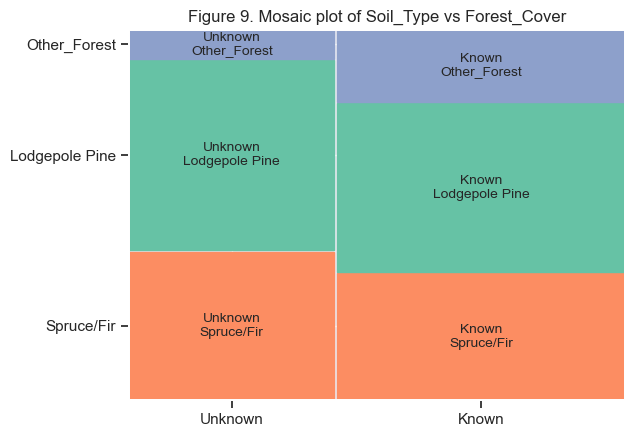

In [857]:
palette = sns.color_palette("Set2", n_colors=3)
cover_classes = ['Lodgepole Pine', 'Spruce/Fir', 'Other_Forest']

def props_func(key):
    idx = cover_classes.index(key[1])
    return {'color': palette[idx]}

mosaic(forest_cover, [cat_var, target], properties=props_func)
plt.title(f"Figure 9. Mosaic plot of {cat_var} vs {target}")
plt.show()

### Statistical Testing of Soil Type-Forest Cover Relationship

In [858]:
# Soil_Type vs Forest_Cover
cont = pd.crosstab(forest_cover["Soil_Type"], forest_cover[target])
chi2, p, dof, expected = chi2_contingency(cont)

# Wilderness_Area vs Forest_Cover
cont2 = pd.crosstab(forest_cover["Wilderness_Area"], forest_cover[target])
chi2_2, p2, dof2, expected2 = chi2_contingency(cont2)

chi_results = pd.DataFrame({
    "Test": ["Soil_Type vs Forest_Cover", "Wilderness_Area vs Forest_Cover"],
    "Chi²": [f"{chi2:.2f}", f"{chi2_2:.2f}"],
    "df": [dof, dof2],
    "p-value": [f"{p:.3g}", f"{p2:.3g}"]
})
chi_results.style.set_caption("Table 6. Chi-Square Test Results")

,Test,Chi²,df,p-value
0,Soil_Type vs Forest_Cover,835.82,2,3.19e-182
1,Wilderness_Area vs Forest_Cover,6014.05,4,0
